<a href="https://colab.research.google.com/github/rifadukrifat-0035/Test-class/blob/main/Mod_9_Project_Object_Tracking_%26_Heatmap_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cell-01  Install dependencies**
# Installs required packages (Ultralytics YOLOv8, OpenCV, etc.)

In [1]:

!pip install -q ultralytics opencv-python-headless numpy matplotlib scipy wget


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00


#**Cell- 02  Upload  video file**

In [2]:
from pathlib import Path
VIDEO_PATH = "/content/people-walking.mp4"

if not Path(VIDEO_PATH).exists():
    print("Video not found at", VIDEO_PATH, "\nAttempting to download sample...")
    import wget
    sample_url = "https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
    wget.download(sample_url, VIDEO_PATH)
    print("\nDownloaded sample to", VIDEO_PATH)
else:
    print("Found video at", VIDEO_PATH)


Video not found at /content/people-walking.mp4 
Attempting to download sample...

Downloaded sample to /content/people-walking.mp4


# **Cell-03 Configuration**
Tweak model, thresholds, line positions here. Keep this cell editable.

In [3]:
VIDEO_FILE = "/content/people-walking.mp4"
OUTPUT_VIDEO = "output_counted.mp4"
HEATMAP_IMG = "final_heatmap.png"
HEATMAP_ACC_NPY = "heatmap_acc.npy"
COUNTS_FILE = "counts.txt"

MODEL_FILE = "yolov8n.pt"     # yolov8n -> fast; use yolov8m.pt or yolov8l.pt for better accuracy (GPU recommended)
CONF_THRESH = 0.30            # detection confidence threshold
LINE_UP_RATIO = 0.35          # upper horizontal line position (fraction of frame height)
LINE_DOWN_RATIO = 0.65        # lower horizontal line position (fraction of frame height)
HEATMAP_DOWNSCALE = 4        # downscale factor for heatmap accumulator (higher -> faster, lower resolution)
DEVICE = "0"                  # "0" for GPU, or "cpu"
TRACKER = "bytetrack"         # tracker to use: bytetrack, sort, etc.
MIN_TRACK_FRAMES_TO_COUNT = 3 # reduce false positives by requiring IDs seen for a few frames

print("Config ready. Edit these variables before running the pipeline if needed.")


Config ready. Edit these variables before running the pipeline if needed.


# **Cell-04 Quick info: model load & frame dimensions (run this)**
Loads model weights (auto-download if needed) and prints video/frame info and computed line y-coordinates.

In [4]:
import cv2
from ultralytics import YOLO

model = YOLO(MODEL_FILE)
cap = cv2.VideoCapture(VIDEO_FILE)
if not cap.isOpened():
    raise RuntimeError("Cannot open video file: " + VIDEO_FILE)
frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
cap.release()

line_up = int(frame_h * LINE_UP_RATIO)
line_down = int(frame_h * LINE_DOWN_RATIO)

print(f"Video: {VIDEO_FILE}")
print(f"Frame size: {frame_w} x {frame_h}, FPS: {fps}")
print(f"Computed lines -> line_up (y) = {line_up}, line_down (y) = {line_down}")
print("Model loaded:", MODEL_FILE)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Video: /content/people-walking.mp4
Frame size: 1920 x 1080, FPS: 25.0
Computed lines -> line_up (y) = 378, line_down (y) = 702
Model loaded: yolov8n.pt


# **Cell-05 Main processing: Detection, Tracking, Counting, Heatmap accumulation**
This is the main cell. It will stream through frames, draw boxes+IDs, update IN/OUT counters, and accumulate centers for the heatmap.

In [5]:
import numpy as np
import cv2
import time
from scipy.ndimage import gaussian_filter
import os # Import os module to check for file existence

# helper to draw text with background
def draw_text(img, text, org, scale=0.6, color=(255,255,255), thickness=1, bg=(0,0,0)):
    x, y = org
    (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, scale, thickness)
    cv2.rectangle(img, (x-2, y-h-2), (x+w+2, y+4), bg, -1)
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness, lineType=cv2.LINE_AA)

# prepare writer
cap = cv2.VideoCapture(VIDEO_FILE)
frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
cap.release()

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_w, frame_h))

# compute lines
line_up = int(frame_h * LINE_UP_RATIO)
line_down = int(frame_h * LINE_DOWN_RATIO)

# tracking state
last_positions = {}   # id -> (x,y)
id_frame_count = {}   # id -> frames seen
counted_ids = set()   # ids already counted (prevents double count)
count_in = 0
count_out = 0

# heatmap accumulator (downsampled)
hm_h = max(1, frame_h // HEATMAP_DOWNSCALE)
hm_w = max(1, frame_w // HEATMAP_DOWNSCALE)
heatmap_acc = np.zeros((hm_h, hm_w), dtype=np.float32)

# Check if the default bytetrack.yaml exists, otherwise use the provided tracker string as a file path
tracker_config = TRACKER
if os.path.exists(TRACKER):
    tracker_config = TRACKER
elif TRACKER == "bytetrack":
    tracker_config = "bytetrack.yaml" # Use default bytetrack config file
    # If the default config file doesn't exist, the model.track method will handle downloading it.
elif TRACKER == "sort":
    tracker_config = "sort.yaml" # Use default sort config file
    # If the default config file doesn't exist, the model.track method will handle downloading it.
else:
    print(f"WARNING: Tracker '{TRACKER}' not recognized as a file path or a default tracker name. Attempting to use it as a file path.")


print("Processing video with model.track(...) — this may take time depending on GPU and model size.")
t0 = time.time()
stream = model.track(VIDEO_FILE, tracker=tracker_config, persist=False, device=DEVICE, stream=True)

frame_idx = 0
for res in stream:
    frame = res.orig_img.copy()
    frame_idx += 1

    boxes = getattr(res, "boxes", None)
    if boxes is None or len(boxes) == 0:
        # draw lines & counters even if no detections
        cv2.line(frame, (0, line_up), (frame_w, line_up), (0,255,255), 2)
        cv2.line(frame, (0, line_down), (frame_w, line_down), (0,255,255), 2)
        draw_text(frame, f"IN: {count_in}", (10,30), scale=0.8, bg=(0,120,0))
        draw_text(frame, f"OUT: {count_out}", (10,60), scale=0.8, bg=(120,0,0))
        out.write(frame)
        continue

    xyxy = boxes.xyxy.cpu().numpy()
    confs = boxes.conf.cpu().numpy()
    clss = boxes.cls.cpu().numpy().astype(int)
    try:
        ids = boxes.id.cpu().numpy().astype(int)
    except Exception:
        ids = -np.ones((len(xyxy),), dtype=int)

    for (x1, y1, x2, y2), conf, cls, oid in zip(xyxy, confs, clss, ids):
        if conf < CONF_THRESH or cls != 0:
            continue
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # heatmap accumulation
        hx = int(cx // HEATMAP_DOWNSCALE)
        hy = int(cy // HEATMAP_DOWNSCALE)
        if 0 <= hy < hm_h and 0 <= hx < hm_w:
            heatmap_acc[hy, hx] += 1.0

        # draw bbox and id
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,200,255), 2)
        id_text = f"ID {int(oid)}" if oid >= 0 else "ID ?"
        draw_text(frame, id_text, (x1, y1-6), scale=0.5, bg=(0,0,0))
        cv2.circle(frame, (cx, cy), 3, (0,255,0), -1)

        # update id frame count
        if oid >= 0:
            id_frame_count[oid] = id_frame_count.get(oid, 0) + 1
            eligible = id_frame_count[oid] >= MIN_TRACK_FRAMES_TO_COUNT

            if oid in last_positions:
                prev_x, prev_y = last_positions[oid]
                dy = cy - prev_y

                # IN: moving down crossing upper line
                if eligible and prev_y < line_up and cy >= line_up and dy > 0 and oid not in counted_ids:
                    count_in += 1
                    counted_ids.add(oid)

                # OUT: moving up crossing lower line
                if eligible and prev_y > line_down and cy <= line_down and dy < 0 and oid not in counted_ids:
                    count_out += 1
                    counted_ids.add(oid)

            last_positions[oid] = (cx, cy)

    # draw lines & counters
    cv2.line(frame, (0, line_up), (frame_w, line_up), (0,255,255), 2)
    cv2.line(frame, (0, line_down), (frame_w, line_down), (0,255,255), 2)
    draw_text(frame, f"IN: {count_in}", (10,30), scale=0.8, bg=(0,120,0))
    draw_text(frame, f"OUT: {count_out}", (10,60), scale=0.8, bg=(120,0,0))

    out.write(frame)

out.release()
t1 = time.time()
print(f"Finished. Frames processed: {frame_idx}. Time elapsed: {t1-t0:.1f}s")
print("Final counts -> IN:", count_in, "OUT:", count_out)

# save accumulator and counts for next step
np.save(HEATMAP_ACC_NPY, heatmap_acc)
with open(COUNTS_FILE, "w") as f:
    f.write(f"{count_in},{count_out}")
print("Saved heatmap accumulator and counts.")

Processing video with model.track(...) — this may take time depending on GPU and model size.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


video 1/1 (frame 1/341) /content/people-walking.mp4: 384x640 37 persons, 2 birds, 73.9ms
video 1/1 (frame 2/341) /content/people-walking.mp4: 384x640 36 persons, 2 birds, 8.6ms
video 1/1 (frame 3/341) /content/people-walking.mp4: 384x640 35 persons, 3 birds, 9.0ms
video 1/1 (frame 4/341) /content/people-walking.mp4: 384x640 35 persons, 3 birds, 9.0ms
video 1/1 (frame 5/341) /content/people-walking.mp4: 384x640 34 persons, 2 birds, 8.3ms
video 1/1 (frame 6/341) /content/people-walking.mp4: 384x640 37 persons, 2 birds, 9.0ms
video 1/1 (frame 7/341) /content/people-walking.mp4: 384x640 36 persons, 2 birds, 9.2ms
video 1/1 (frame 8/341) /content/people-walking.mp4: 384x640 37 persons,

# **Cell-06 Create final heatmap image and preview**


Saved heatmap image: final_heatmap.png


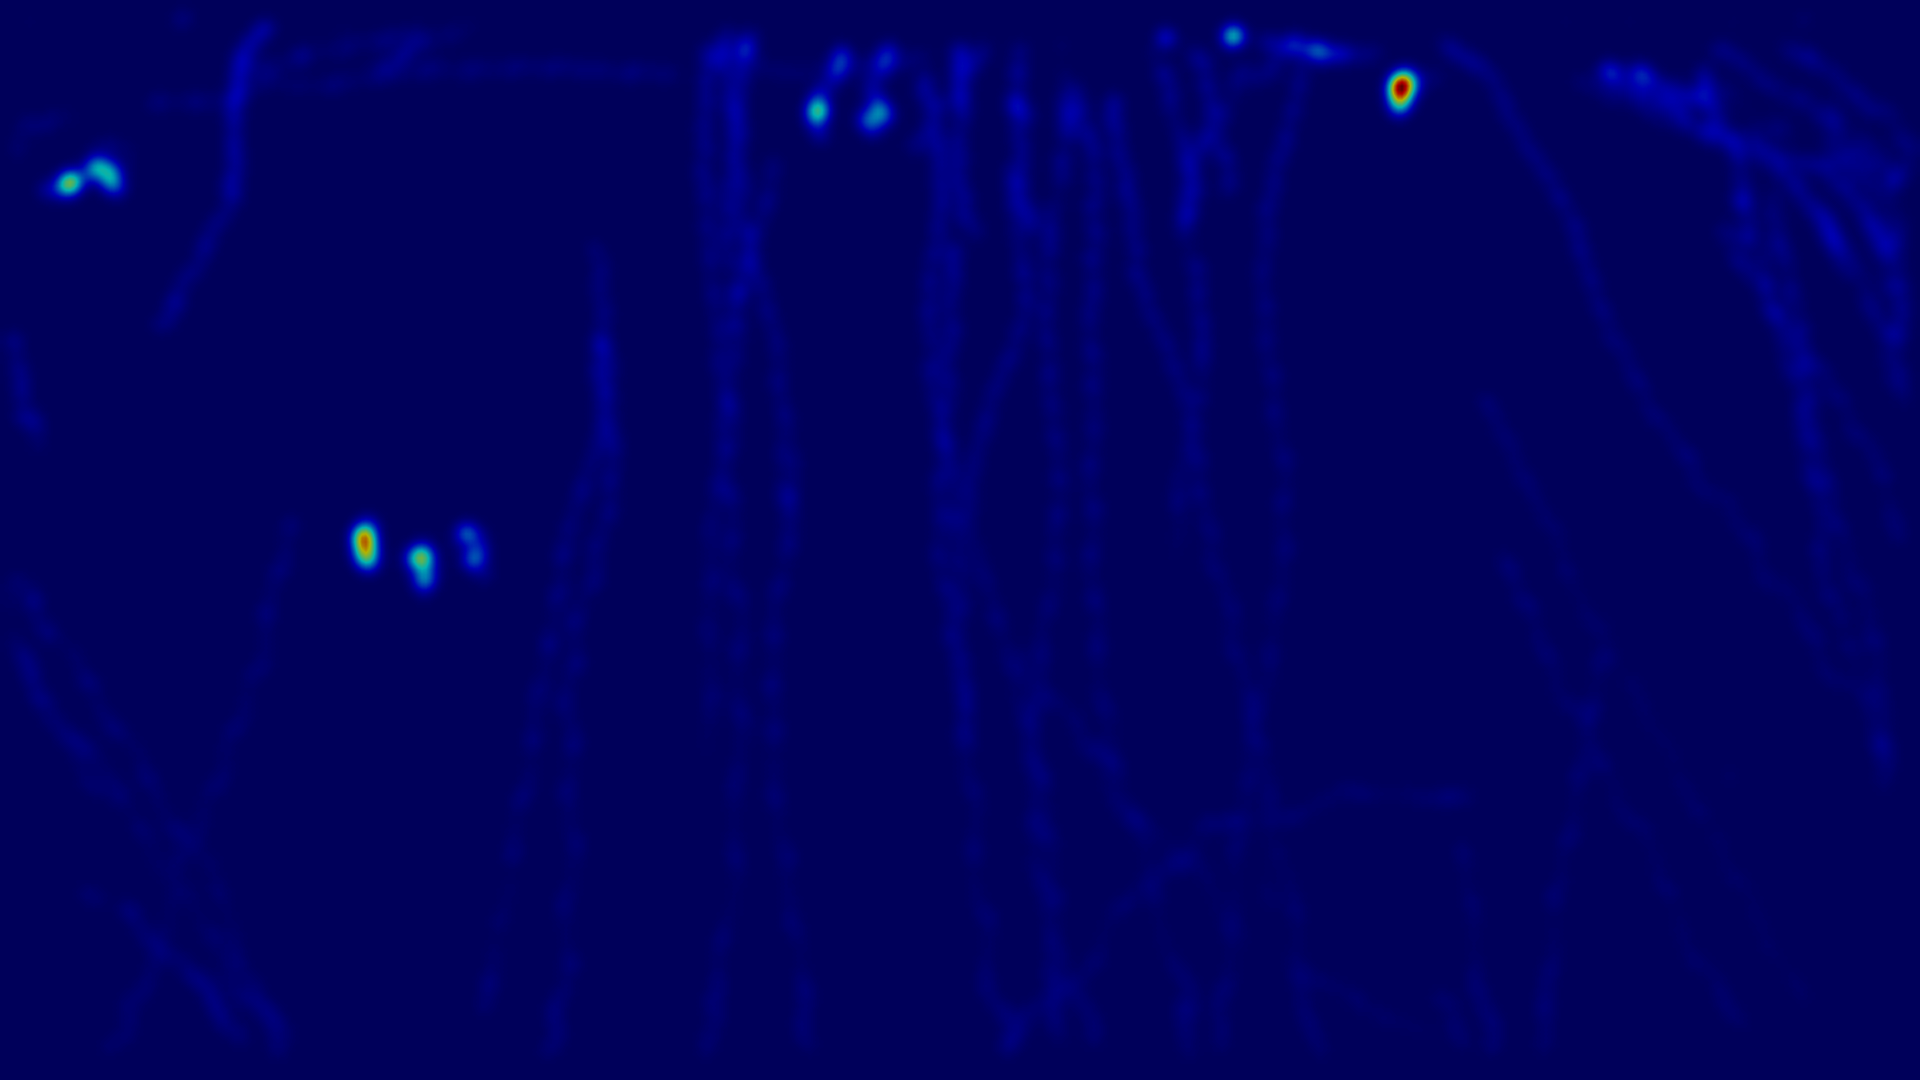

In [6]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from IPython.display import Image, display

heatmap_acc = np.load(HEATMAP_ACC_NPY)
cap = cv2.VideoCapture(VIDEO_FILE)
frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

if heatmap_acc.max() <= 0:
    print("Heatmap is empty. No detections accumulated.")
    blank = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.imwrite(HEATMAP_IMG, blank)
else:
    # Adjust these values for a clearer heatmap
    GAUSSIAN_SIGMA = 2.0  # Increase for more smoothing, decrease for less
    OVERLAY_ALPHA = 0.7   # Increase for less transparency, decrease for more transparency

    hm_blur = gaussian_filter(heatmap_acc, sigma=GAUSSIAN_SIGMA)
    hm_norm = np.uint8(255 * (hm_blur / hm_blur.max()))
    hm_up = cv2.resize(hm_norm, (frame_w, frame_h), interpolation=cv2.INTER_LINEAR)
    heatmap_color = cv2.applyColorMap(hm_up, cv2.COLORMAP_JET)

    # Create a black background image to overlay the heatmap on
    black_background = np.zeros_like(heatmap_color)
    overlay = cv2.addWeighted(heatmap_color, OVERLAY_ALPHA, black_background, 1 - OVERLAY_ALPHA, 0)

    cv2.imwrite(HEATMAP_IMG, overlay)
    print("Saved heatmap image:", HEATMAP_IMG)
    display(Image(HEATMAP_IMG))

# **Cell 7 — Results summary & README**

In [7]:

with open(COUNTS_FILE) as f:
    s = f.read().strip().split(",")
count_in, count_out = int(s[0]), int(s[1])

cap = cv2.VideoCapture(VIDEO_FILE)
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
cap.release()
line_up = int(frame_h * LINE_UP_RATIO)
line_down = int(frame_h * LINE_DOWN_RATIO)

print("=== RESULTS ===")
print("IN:", count_in, "OUT:", count_out)
print("line_up (y):", line_up)
print("line_down (y):", line_down)
print("Annotated video:", OUTPUT_VIDEO)
print("Heatmap image:", HEATMAP_IMG)

readme = f'''
Detection method: YOLOv8 (Ultralytics) - model {MODEL_FILE}. Tracker: {TRACKER}
Line coordinates (pixels): line_up = {line_up}, line_down = {line_down}
Counting logic:
 - For each tracked ID, store previous center (x_prev,y_prev).
 - If previous y_prev < line_up and current y >= line_up and movement downward -> IN.
 - If previous y_prev > line_down and current y <= line_down and movement upward -> OUT.
Files produced:
 - {OUTPUT_VIDEO}
 - {HEATMAP_IMG}
 - {HEATMAP_ACC_NPY}
 - {COUNTS_FILE}
'''
print("\nREADME SNIPPET:\n", readme)


=== RESULTS ===
IN: 11 OUT: 9
line_up (y): 378
line_down (y): 702
Annotated video: output_counted.mp4
Heatmap image: final_heatmap.png

README SNIPPET:
 
Detection method: YOLOv8 (Ultralytics) - model yolov8n.pt. Tracker: bytetrack
Line coordinates (pixels): line_up = 378, line_down = 702
Counting logic:
 - For each tracked ID, store previous center (x_prev,y_prev).
 - If previous y_prev < line_up and current y >= line_up and movement downward -> IN.
 - If previous y_prev > line_down and current y <= line_down and movement upward -> OUT.
Files produced:
 - output_counted.mp4
 - final_heatmap.png
 - heatmap_acc.npy
 - counts.txt

